In [ ]:
# Install libraries if not present
!pip install flax optax

# import Libs

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import math
from jax import random
from jax import nn
from flax.training import train_state
import optax
import math
from typing import Iterable, List
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# We still need PyTorch for the data loading part we kept
import torch

# Device configuration (JAX automatically finds GPU/TPU)
print(f"JAX Devices: {jax.devices()}")

JAX Devices: [CudaDevice(id=0)]



```
en_core_web_sm/
│
├── meta.json
├── vocab/
├── tokenizer
├── tagger
├── parser
├── ner
└── config.cfg
```



In [ ]:
import spacy.cli
spacy_de = spacy.cli.download("de_core_news_sm")
spacy_en = spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("bentrevett/multi30k")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset["train"][0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [ ]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [ ]:
def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

In [ ]:
from collections import Counter

def build_vocab(sentences, tokenizer, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer(sentence))

    vocab = {"<pad>":0, "<unk>":1, "<sos>":2, "<eos>":3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [ ]:
import spacy
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

train_en = [d["en"] for d in dataset["train"]]
train_de = [d["de"] for d in dataset["train"]]

print("Building English Vocab...")
vocab_en = build_vocab(train_en, tokenize_en)

print("Building German Vocab...")
vocab_de = build_vocab(train_de, tokenize_de)

Building English Vocab...
Building German Vocab...


# Encoding

In [ ]:
def encode_sentence(sentence, vocab):
    tokens = sentence.lower().split()
    return [vocab.get("<sos>")] + [vocab.get(t, vocab["<unk>"]) for t in tokens] + [vocab.get("<eos>")]

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence # Also needed for collate_fn
import torch # Ensure torch is available for torch.tensor

print("Example encoded DE sentence:", encode_sentence(train_de[0], vocab_de))

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src, tgt in batch:
        src_batch.append(torch.tensor(encode_sentence(src, vocab_de)))
        tgt_batch.append(torch.tensor(encode_sentence(tgt, vocab_en)))
    src_batch = pad_sequence(src_batch, padding_value=vocab_de["<pad>"])
    tgt_batch = pad_sequence(tgt_batch, padding_value=vocab_en["<pad>"])
    return src_batch, tgt_batch

train_data = list(zip(train_de, train_en))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

for src, tgt in train_loader:
    print("Source batch shape:", src.shape)
    print("Target batch shape:", tgt.shape)
    break

Example encoded DE sentence: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 3]
Source batch shape: torch.Size([23, 32])
Target batch shape: torch.Size([23, 32])


In [ ]:
for src, tgt in train_loader:
    print("Source IDs:", src)
    print("Target IDs:", tgt)
    break

Source IDs: tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2],
        [  21,   47,   47,   21,   21,   21,    4,   21,   21,   21,   21,   21,
           21, 2787,   21,   47,    4,   12,  219,   21,   47,    4,    4,   47,
            4,   21,   47,  286,  160,   21,   47,   21],
        [ 130,  134,    1,   28,   28,   28,    7, 1637,    5,    1,    1,   28,
          182,   28,   28,  124,    7,   28, 1146,   93,   67,    7,   73,   67,
          102,  125,  749,    7,  162, 3334,  150,    5],
        [ 785,  135,   65, 3455,   18,   36, 7587,  390,  154,    9,   12,   11,
           28,   11,   18,   84, 3113,    9,    1,  158,  423, 4238,  923,   18,
           43,   28,   18,   39,  148,  298,   18,   36],
        [  11,  110,   58,   33,  107,   47, 4245,    9,   21, 7317,   47,  363,
          249,    1,  117, 

In [ ]:
data_itr = iter(train_loader)
src, tgt = next(data_itr)
print("Source batch IDs:", src)
print("Target batch IDs:", tgt)

Source batch IDs: tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2],
        [  21,   17,   47,   63,    4,   21,   21,   21,   21,  170,   21,   47,
           21,   21,   21,   47,   21,   47,   21,   21,   47,    4,   21,   21,
           21,   79,   86,   21,   21,   21,   21,   21],
        [ 346,  120,   67,  780,   73,   23,   28,  346,   23,   28,  162,  150,
          170,  170,   28,  124,   28,   67,    5,   28, 1182, 2772,   28,  363,
         5724,  458,  142,    5,  345,   28,   28,  170],
        [ 110,  362, 4556,   12,   11,   18,   18, 4409,  126,   33,   11,   18,
           28,   28,  265,   84, 1261,   11,  110,   18,   67,    1,   18, 1366,
         1388, 4238, 5081,  110, 6601,   36,   36,   28],
        [  33,   33,   40, 1679,  253, 1999,   29,  248,    1,   29,   29,    4,
           11,  529, 

In [ ]:
data_iterator = iter(train_loader)
for n in range(1000):
    try:
        german, english = next(data_iterator)
        print(german.shape, english.shape)
    except StopIteration:
        print("End of data reached.")
        break

torch.Size([23, 32]) torch.Size([27, 32])
torch.Size([17, 32]) torch.Size([24, 32])
torch.Size([20, 32]) torch.Size([21, 32])
torch.Size([22, 32]) torch.Size([21, 32])
torch.Size([21, 32]) torch.Size([24, 32])
torch.Size([21, 32]) torch.Size([23, 32])
torch.Size([22, 32]) torch.Size([24, 32])
torch.Size([21, 32]) torch.Size([24, 32])
torch.Size([20, 32]) torch.Size([19, 32])
torch.Size([27, 32]) torch.Size([26, 32])
torch.Size([24, 32]) torch.Size([24, 32])
torch.Size([34, 32]) torch.Size([36, 32])
torch.Size([22, 32]) torch.Size([25, 32])
torch.Size([23, 32]) torch.Size([24, 32])
torch.Size([23, 32]) torch.Size([21, 32])
torch.Size([21, 32]) torch.Size([25, 32])
torch.Size([23, 32]) torch.Size([21, 32])
torch.Size([24, 32]) torch.Size([26, 32])
torch.Size([21, 32]) torch.Size([24, 32])
torch.Size([22, 32]) torch.Size([25, 32])
torch.Size([26, 32]) torch.Size([26, 32])
torch.Size([22, 32]) torch.Size([25, 32])
torch.Size([30, 32]) torch.Size([27, 32])
torch.Size([20, 32]) torch.Size([2

In [ ]:
german=german.T
english=english.T

In [ ]:
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<pad>', '<unk>', '<sos>', '<eos>']

In [ ]:
data_iterator = iter(train_loader)

idx_to_word_de = {v: k for k, v in vocab_de.items()}
idx_to_word_en = {v: k for k, v in vocab_en.items()}

def decode_sentence(tensor_ids, idx_to_word_vocab):
    words = []
    for idx in tensor_ids.tolist():
        word = idx_to_word_vocab.get(idx, "<unk>")
        if word not in ["<pad>"]:
            words.append(word)
    return " ".join(words)

for n in range(10):
    try:
        german_batch, english_batch = next(data_iterator)

        german_sentence_ids = german_batch[:, 0]
        english_sentence_ids = english_batch[:, 0]

        print(f"sample {n}")
        print("german input")
        print(decode_sentence(german_sentence_ids, idx_to_word_de))
        print("english target")
        print(decode_sentence(english_sentence_ids, idx_to_word_en))
        print("_________\n")

    except StopIteration:
        print(f"End of data reached after {n} samples.")
        break


sample 0
german input
<sos> eine langhaarige frau mit sonnenbrille tanzt mit zwei anderen personen in einer <unk> <eos>
english target
<sos> a <unk> woman with sunglasses is dancing with two other people in a <unk> <eos>
_________

sample 1
german input
<sos> eine gruppe unterschiedlicher menschen sitzt auf den stufen und der halbhohen mauer vor einer <unk> <eos>
english target
<sos> a diverse group of people sitting on the steps and half wall in front of a <unk> <eos>
_________

sample 2
german input
<sos> eine frau singt ins <unk> <eos>
english target
<sos> a woman singing into a <unk> <eos>
_________

sample 3
german input
<sos> zwei kinder <unk> während sie sich auf ihren sprung ins wasser <unk> <eos>
english target
<sos> two children smile as they prepare to make their big <unk> <eos>
_________

sample 4
german input
<sos> ein mann mit einer <unk> hält einen weißen umhang und steht mit zwei anderen männern auf einem <unk> <eos>
english target
<sos> a man in an <unk> hat holding a 

In [ ]:
import numpy as np
def numpy_collate(batch):
    # Convert PyTorch tensors to Numpy arrays
    # And Transpose to be (Batch, Seq_Len) because Flax prefers batch_first
    src, tgt = batch
    return np.array(src).T, np.array(tgt).T

# Example usage (Testing the shape)
# Assuming train_loader is already defined from previous cells
sample_src, sample_tgt = numpy_collate(next(iter(train_loader)))
print(f"Source Shape (Batch, Seq): {sample_src.shape}")

Source Shape (Batch, Seq): (32, 23)


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Masking

In [ ]:
def make_masks(src, tgt, pad_idx):
    # Source Mask (Padding Mask only) -> (Batch, 1, 1, Src_Len)
    src_mask = (src != pad_idx)[:, None, None, :]

    # Target Mask (Causal Mask & Padding Mask)
    # 1. Padding mask
    tgt_pad_mask = (tgt != pad_idx)[:, None, None, :]

    # 2. Causal mask (Lower Triangular)
    seq_len = tgt.shape[1]
    causal_mask = jnp.tril(jnp.ones((seq_len, seq_len))).astype(bool) # (Seq, Seq)
    causal_mask = causal_mask[None, None, :, :] # Expand dims

    # Combine
    tgt_mask = jnp.logical_and(tgt_pad_mask, causal_mask)

    return src_mask, tgt_mask

# Positional encoding

In [ ]:
import flax.linen as nn
import jax.numpy as jnp
import math

class PositionalEncoding(nn.Module):
    emb_size: int
    max_len: int = 5000
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, train=True):
        # x shape: (batch_size, seq_len, emb_size)
        seq_len = x.shape[1]

        # den
        position = jnp.arange(seq_len, dtype=jnp.float32)[:, None]
        div_term = jnp.exp(jnp.arange(0, self.emb_size, 2) * -(math.log(10000.0) / self.emb_size))

        # postional encoding
        pe = jnp.zeros((seq_len, self.emb_size))
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))

        # reshape to be batch first
        pe = pe[None, :, :] # shape: (1, seq_len, emb_size)

        x = x + pe # add positional encoding
        return nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)

#Token embedding

In [ ]:
class TokenEmbedding(nn.Module):
    vocab_size: int
    emb_size: int

    @nn.compact
    def __call__(self, tokens):
        # nn.Embed will take indices and will convert them to vectors
        embedding = nn.Embed(num_embeddings=self.vocab_size , features = self.emb_size)(tokens)
        return embedding * math.sqrt(self.emb_size)

#  Multihead Attention Wrapper

In [ ]:
class MultiHeadAttention(nn.Module):
    emb_size: int
    num_heads: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, query, key, value, mask=None, train=True):
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.emb_size,
            dropout_rate=self.dropout_rate,
            deterministic=not train,
        )(inputs_q=query, inputs_k=key, inputs_v=value, mask=mask)

        return attn_output

# FeedForward

In [ ]:
class FeedForward(nn.Module):
    emb_size : int
    dim_feedforward : int
    dropout_rate : float = 0.1

    @nn.compact
    def __call__(self, x, train=True):
        x = nn.Dense(self.dim_feedforward)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(self.emb_size)(x)
        return x

# Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    emb_size: int
    num_heads: int
    dim_feedforward: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, src, src_mask=None, train=True):
        # Multihead attention + Add & Norm
        src2 = MultiHeadAttention(self.emb_size, self.num_heads, self.dropout_rate)(src, src, src, mask=src_mask, train=train)
        src = nn.LayerNorm()(src + src2)
        # Feedforward + Add & Norm
        src2 = FeedForward(self.emb_size, self.dim_feedforward, self.dropout_rate)(src, train=train)
        src = nn.LayerNorm()(src + src2)
        return src

#  Decoder Layer


In [ ]:
class DecoderLayer(nn.Module):
    emb_size: int
    num_heads: int
    dim_feedforward: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, tgt, memory, tgt_mask=None, memory_mask=None, train=True):
        # Masked Self-Attention
        tgt2 = MultiHeadAttention(self.emb_size, self.num_heads, self.dropout_rate)(tgt, tgt, tgt, mask=tgt_mask, train=train)
        tgt = nn.LayerNorm()(tgt + tgt2)

        # Cross-Attention
        tgt2 = MultiHeadAttention(self.emb_size, self.num_heads, self.dropout_rate)(tgt, memory, memory, mask=memory_mask, train=train)
        tgt = nn.LayerNorm()(tgt + tgt2)

        # Feed Forward
        tgt2 = FeedForward(self.emb_size, self.dim_feedforward, self.dropout_rate)(tgt, train=train)
        tgt = nn.LayerNorm()(tgt + tgt2)
        return tgt

# Seq2Seq Transformer

In [ ]:
import flax.linen as nn

class Seq2SeqTransformer(nn.Module):
    src_vocab_size: int
    tgt_vocab_size: int
    emb_size: int
    num_heads: int
    num_encoder_layers: int
    num_decoder_layers: int
    dim_feedforward: int = 512
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, train=True):
        # Embeddings + Positional Encoding
        src_emb = PositionalEncoding(self.emb_size, dropout_rate=self.dropout_rate)(TokenEmbedding(self.src_vocab_size, self.emb_size)(src), train=train)
        tgt_emb = PositionalEncoding(self.emb_size, dropout_rate=self.dropout_rate)(TokenEmbedding(self.tgt_vocab_size, self.emb_size)(tgt), train=train)

        # Encoder
        memory = src_emb
        for _ in range(self.num_encoder_layers):
            memory = EncoderLayer(self.emb_size, self.num_heads, self.dim_feedforward, self.dropout_rate)(memory, src_mask, train=train)

        # Decoder
        output = tgt_emb
        for _ in range(self.num_decoder_layers):
            output = DecoderLayer(self.emb_size, self.num_heads, self.dim_feedforward, self.dropout_rate)(output, memory, tgt_mask, memory_mask, train=train)

        # Final Linear Layer
        logits = nn.Dense(self.tgt_vocab_size)(output)
        return logits

# Inference

In [ ]:
import jax
import jax.numpy as jnp

# Hyperparameters
SRC_VOCAB_SIZE = len(vocab_de)
TGT_VOCAB_SIZE = len(vocab_en)
EMB_SIZE = 256
NHEAD = 4
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

In [ ]:
transformer = Seq2SeqTransformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    emb_size=EMB_SIZE,
    num_heads=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=FFN_HID_DIM,
    dropout_rate=0.1
)

In [ ]:
# (Initialization)
dummy_src = jnp.ones((BATCH_SIZE, 10), dtype=jnp.int32)
dummy_tgt = jnp.ones((BATCH_SIZE, 10), dtype=jnp.int32)

rng = jax.random.PRNGKey(0) # Random Seed JAX
variables = transformer.init(rng, dummy_src, dummy_tgt)
params = variables['params']

print("Model initialized successfully!")
print(f"Number of params: {sum(x.size for x in jax.tree_util.tree_leaves(params)):,}")

Model initialized successfully!
Number of params: 8,987,141


# Greedy Decode

In [ ]:
def greedy_decode(params, src, max_len, start_symbol):
    # 1. Prepare inputs
    # src shape: (1, seq_len)
    # Create source mask once (padding mask only)
    src_mask, _ = make_masks(src, src, 0)  # 0 is PAD_IDX

    # Start with [SOS]
    ys = jnp.array([[start_symbol]], dtype=jnp.int32)

    for i in range(max_len - 1):
        # 2. Prepare current target masks
        # Current target sequence is ys
        _, tgt_mask = make_masks(src, ys, 0)

        # 3. Forward pass through the model
        # Pass params explicitly to the model
        # Note: src_mask is passed twice:
        # - once as src_mask
        # - once as memory_mask for cross-attention
        logits = transformer.apply(
            {'params': params},
            src,
            ys,
            src_mask,
            tgt_mask,
            src_mask,
            train=False
        )

        # 4. Select the token with the highest probability for the last position
        next_word_logits = logits[:, -1, :]  # only the last time step
        next_word = jnp.argmax(next_word_logits, axis=-1)

        # 5. Append the selected token to the generated sequence
        ys = jnp.concatenate([ys, next_word[:, None]], axis=1)

        # Stop decoding if EOS token is generated
        if next_word.item() == 3:  # EOS_IDX
            break

    return ys


In [ ]:
import jax.numpy as jnp

# 1. Get one batch from the data (for testing)
# Use the defined `train_loader` and ensure it's not exhausted by getting a new iterator
data_iterator_test = iter(train_loader)
src_batch, tgt_batch = next(data_iterator_test)

# 2. Convert data to JAX NumPy arrays and transpose to (batch_size, seq_len)
# The `collate_fn` outputs (seq_len, batch_size), but JAX models often prefer (batch_size, seq_len)
src = jnp.array(src_batch.numpy()).T
tgt = jnp.array(tgt_batch.numpy()).T

# 3. Prepare tgt_input for Teacher Forcing and tgt_out for loss calculation
# tgt_input: Remove the last token so the model does not see future tokens
tgt_input = tgt[:, :-1]
# tgt_out: Remove the first token as it's the target for prediction (after shifting)
tgt_out = tgt[:, 1:]

print(f"Source Shape: {src.shape}")
print(f"Target Input Shape: {tgt_input.shape}")
print(f"Target Output Shape: {tgt_out.shape}")
print("-" * 30)

# Create source and target masks
src_mask, tgt_mask = make_masks(src, tgt_input, PAD_IDX)  # PAD_IDX is defined

# Run the forward pass of the transformer
logits = transformer.apply(
    {'params': params}, # Changed 'state.params' to 'params'
    src,
    tgt_input,
    src_mask,
    tgt_mask,
    src_mask,
    train=False
)

# Print the shape of the output logits
print(f"Logits shape (Batch, Seq, Vocab): {logits.shape}")

Source Shape: (32, 24)
Target Input Shape: (32, 22)
Target Output Shape: (32, 22)
------------------------------
Logits shape (Batch, Seq, Vocab): (32, 22, 5893)


In [ ]:
# Flatten the logits tensor
# Original shape: (Batch, Sequence length, Vocabulary size)
# New shape: (Batch * Sequence length, Vocabulary size)
logits_flattened = logits.reshape(-1, logits.shape[-1])

# Flatten the target output tensor
# Original shape: (Batch, Sequence length)
# New shape: (Batch * Sequence length)
tgt_out_flattened = tgt_out.reshape(-1)

# Print the shapes after flattening
# These shapes are typically used for loss computation
print(f"Flatted Logits: {logits_flattened.shape}")
print(f"Flatted Targets: {tgt_out_flattened.shape}")

Flatted Logits: (704, 5893)
Flatted Targets: (704,)


In [ ]:
# Convert target tokens to one-hot encoding
one_hot_labels = jax.nn.one_hot(tgt_out_flattened, num_classes=logits.shape[-1])

# Compute cross-entropy loss for each token
loss_per_token = optax.softmax_cross_entropy(logits_flattened, one_hot_labels)

# Create padding mask (0 is PAD token)
padding_mask = (tgt_out_flattened != 0)

# Apply mask to ignore padding tokens in loss
loss_masked = loss_per_token * padding_mask

# Compute final loss by averaging over non-padding tokens
final_loss = loss_masked.sum() / padding_mask.sum()

# Print final loss value
print(f"Final Loss: {final_loss}")

Final Loss: 9.432088851928711


#  Define the evaluation step (JIT compiled for speed)

In [ ]:
@jax.jit
def eval_step(state, src, tgt):
    # Prepare target inputs and outputs
    tgt_input = tgt[:, :-1]
    tgt_y = tgt[:, 1:]

    # Create masks
    src_mask, tgt_mask = make_masks(src, tgt_input, 0)  # 0 is PAD

    # Run model forward pass
    # Note: train=False to disable dropout
    logits = transformer.apply(
        {'params': state.params},
        src, tgt_input, src_mask, tgt_mask, src_mask,
        train=False
    )

    # Compute loss
    loss = compute_loss(logits, tgt_y)
    return loss


# 2. Main evaluation function
def evaluate(state, dataloader):
    losses = []

    # Loop over validation data
    for src_batch, tgt_batch in dataloader:
        # Convert data to JAX arrays and TRANSPOSE to (batch_size, seq_len)
        src = jnp.array(src_batch.numpy()).T
        tgt = jnp.array(tgt_batch.numpy()).T

        # Compute loss for this batch
        loss = eval_step(state, src, tgt)
        losses.append(loss)

    # Return average loss
    return jnp.mean(jnp.array(losses))

In [ ]:
def compute_loss(logits, labels):
    # logits shape: (batch, seq_len, vocab_size)
    # labels shape: (batch, seq_len)

    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot)

    # Ignore padding (pad_idx = 0)
    mask = (labels != 0)
    loss = loss * mask

    return loss.sum() / mask.sum()

# Train Step

In [ ]:
@jax.jit
def train_step(state, src, tgt, dropout_key):
    tgt_input = tgt[:, :-1]
    tgt_y = tgt[:, 1:]

    src_mask, tgt_mask = make_masks(src, tgt_input, 0) # 0 is PAD_IDX

    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            src, tgt_input, src_mask, tgt_mask, src_mask,
            train=True,
            rngs={'dropout': dropout_key}
        )
        loss = compute_loss(logits, tgt_y)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)

    state = state.apply_gradients(grads=grads)
    return state, loss

# Translate Sentence

In [ ]:
def translate_sentence(sentence, params, max_len=50):
    # 1. Tokenize & Encode
    tokens = [vocab_de.get("<sos>")] + [vocab_de.get(token, vocab_de.get("<unk>")) for token in tokenize_de(sentence)] + [vocab_de.get("<eos>")]
    src = jnp.array([tokens]) # Shape (1, seq_len)

    # 2. Decode using existing greedy_decode function
    output_ids = greedy_decode(params, src, max_len=max_len, start_symbol=vocab_en["<sos>"])

    # 3. Convert IDs to Words
    decoded_words = []
    for idx in output_ids[0]:
        idx = int(idx)
        if idx == vocab_en["<eos>"]:
            break
        if idx not in [vocab_en["<sos>"], vocab_en["<pad>"]]:
            decoded_words.append(idx_to_word_en.get(idx, "<unk>"))

    return " ".join(decoded_words)

#  Function to train one full epoch using JAX

In [ ]:
from tqdm.auto import tqdm
import jax.numpy as jnp

def train_epoch(state, dataloader, rng, epoch_idx):
    """
    Function to train one full epoch using JAX
    """
    # Variables to track average loss
    total_loss = 0
    count = 0

    # Progress bar
    # leave=False hides the bar after the epoch ends (optional)
    batch_iterator = tqdm(dataloader, desc=f"Training Epoch {epoch_idx}", leave=False)

    for src_batch, tgt_batch in batch_iterator:
        # 1. Prepare data (JAX prefers NumPy arrays and batch-first format)
        src = jnp.array(src_batch.numpy()).T
        tgt = jnp.array(tgt_batch.numpy()).T

        # 2. Generate a new random key for dropout
        rng, dropout_key = jax.random.split(rng)

        # 3. Training step (using the previously defined train_step)
        # Note: state is updated and returned (functional style)
        state, loss = train_step(state, src, tgt, dropout_key)

        # 4. Update tracking values
        loss_val = loss.item()
        total_loss += loss_val
        count += 1

        # Update progress bar
        batch_iterator.set_postfix(loss=f"{loss_val:.4f}")

    # Return updated state and average loss
    avg_loss = total_loss / count
    return state, avg_loss

In [ ]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from torch.utils.data import DataLoader
import torch # For random_split and tensor

# --- Re-defining dependencies to make this cell self-contained ---
# Hyperparameters (from KFLEhws4nAtW, BsKtTjKN76oB)
SRC_VOCAB_SIZE = len(vocab_de)
TGT_VOCAB_SIZE = len(vocab_en)
EMB_SIZE = 512 # Changed to match KFLEhws4nAtW
NHEAD = 8 # Changed to match KFLEhws4nAtW
FFN_HID_DIM = 512 # Changed to match KFLEhws4nAtW
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10 # Not directly used here, but for context

# 0. Define compute_loss (from WMNrWNsf9Afa, uncommented)
def compute_loss(logits, labels):
    """
    labels shape: (batch, seq_len)
    logits shape: (batch, seq_len, vocab_size)
    """
    one_hot = jax.nn.one_hot(labels, TGT_VOCAB_SIZE)
    loss = optax.softmax_cross_entropy(logits, one_hot)
    mask = (labels != PAD_IDX)  # PAD_IDX is globally defined
    return (loss * mask).sum() / mask.sum()

# 1. Define collate_fn (from JwgpexI7kbB4)
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src, tgt in batch:
        src_batch.append(torch.tensor(encode_sentence(src, vocab_de)))
        tgt_batch.append(torch.tensor(encode_sentence(tgt, vocab_en)))
    # pad_sequence is imported globally via `from torch.nn.utils.rnn import pad_sequence`
    src_batch = pad_sequence(src_batch, padding_value=vocab_de["<pad>"])
    tgt_batch = pad_sequence(tgt_batch, padding_value=vocab_en["<pad>"])
    return src_batch, tgt_batch

# 2. Setup `subset_data` (from riIjdtuTH5Sj)
# train_data is globally available from `JwgpexI7kbB4`
subset_data = train_data[:5000]

# 3. Create val_loader (from CHAF0ShUidv5)
train_size = int(0.9 * len(subset_data))
val_size = len(subset_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    subset_data, [train_size, val_size]
)
val_loader = DataLoader(
    val_subset, batch_size=128, shuffle=False, collate_fn=collate_fn # Assumed collate_fn_fixed is collate_fn
)

# 4. Initialize transformer model (from pK-IYPNv5Z8v or XyLEUQfInF8_)
# Seq2SeqTransformer is globally defined
transformer = Seq2SeqTransformer(
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    EMB_SIZE,
    NHEAD,
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    dim_feedforward=FFN_HID_DIM,
    dropout_rate=0.1
)

# 5. Create optimizer (from XyLEUQfInF8_)
optimizer = optax.adamw(
    learning_rate=0.0005, b1=0.9, b2=0.98, eps=1e-9
)

# 6. Initialize training state (from XyLEUQfInF8_)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

dummy_src = jnp.ones((1, 10), dtype=jnp.int32)
dummy_tgt = jnp.ones((1, 10), dtype=jnp.int32)
params = transformer.init(init_rng, dummy_src, dummy_tgt)['params']

state = train_state.TrainState.create(
    apply_fn=transformer.apply,
    params=params,
    tx=optimizer
)

# --- Original code from the selected cell ---
# The evaluate function is globally defined (JusYns2FiNmk)
val_loss = evaluate(state, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 9.2511


# Split data into training and validation sets (e.g., 90% train, 10% validation)

In [ ]:
train_size = int(0.9 * len(subset_data))
val_size = len(subset_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    subset_data, [train_size, val_size]
)

# Create data loaders
train_dataloader = DataLoader(
    train_subset, batch_size=128, shuffle=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_subset, batch_size=128, shuffle=False, collate_fn=collate_fn
)

# Print number of batches
print(f"Training Batches: {len(train_dataloader)}")
print(f"Validation Batches: {len(val_dataloader)}")

Training Batches: 36
Validation Batches: 4


# Hyperparameters

In [ ]:
import matplotlib.pyplot as plt
from flax.training import checkpoints  # for saving the model
import shutil  # to clean old checkpoints if they exist
import os

#Hyperparameters
SRC_VOCAB_SIZE = len(vocab_de)
TGT_VOCAB_SIZE = len(vocab_en)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10  # increased to better observe the loss curve

# Model Initialization

In [ ]:
# Define the model
transformer = Seq2SeqTransformer(
    SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMB_SIZE, NHEAD,
    NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, FFN_HID_DIM
)

# Create optimizer (AdamW is the Flax equivalent of Adam)
optimizer = optax.adamw(
    learning_rate=0.0005, b1=0.9, b2=0.98, eps=1e-9
)

# Initialize training state
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# Dummy data for parameter initialization
dummy_src = jnp.ones((1, 10), dtype=jnp.int32)
dummy_tgt = jnp.ones((1, 10), dtype=jnp.int32)

params = transformer.init(init_rng, dummy_src, dummy_tgt)['params']

state = train_state.TrainState.create(
    apply_fn=transformer.apply,
    params=params,
    tx=optimizer
)

# Training Loop

In [ ]:
import time
# Training Loop
TrainLoss = []
ValLoss = []

print("Starting Training Loop...")
start_timer = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Train for one epoch
    # Uses the JAX-based train_epoch function
    state, train_loss = train_epoch(state, train_dataloader, rng, epoch)
    TrainLoss.append(train_loss)

    # Evaluate on validation data
    # Uses the JAX-based evaluate function
    val_loss = evaluate(state, val_dataloader)
    ValLoss.append(val_loss)

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch: {epoch} | "
        f"Train Loss: {train_loss:.3f} | "
        f"Val Loss: {val_loss:.3f} | "
        f"Time: {epoch_time:.2f}s"
    )


Starting Training Loop...


Training Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 5.629 | Val Loss: 5.057 | Time: 602.23s


Training Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 5.015 | Val Loss: 5.031 | Time: 239.39s


Training Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 4.873 | Val Loss: 4.532 | Time: 92.76s


Training Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 4.182 | Val Loss: 3.884 | Time: 40.26s


Training Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 3.616 | Val Loss: 3.560 | Time: 75.44s


Training Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 3.186 | Val Loss: 3.309 | Time: 77.02s


Training Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 2.845 | Val Loss: 3.153 | Time: 57.86s


Training Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 2.532 | Val Loss: 3.114 | Time: 74.24s


Training Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 2.251 | Val Loss: 3.059 | Time: 73.60s


Training Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 1.988 | Val Loss: 3.038 | Time: 43.73s


# Saving the Model

In [ ]:
# In Flax, the model is saved as a checkpoint directory
import os
ckpt_dir = os.path.join(os.getcwd(), 'checkpoints_de_en') # Make the path absolute
if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # remove old checkpoints

# Save the final training state
checkpoints.save_checkpoint(
    ckpt_dir=ckpt_dir, target=state, step=NUM_EPOCHS, overwrite=True
)
print(f"Model saved to {ckpt_dir}")

Model saved to /content/checkpoints_de_en


# Plotting

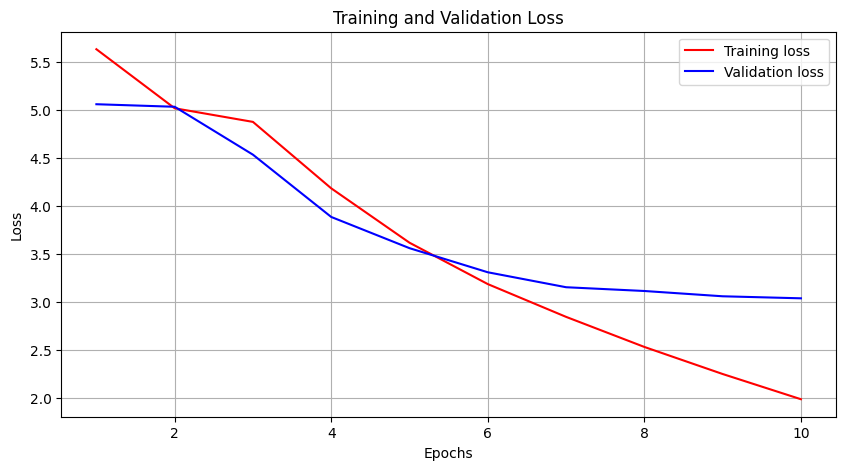

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), TrainLoss, 'r-', label='Training loss')
plt.plot(range(1, NUM_EPOCHS + 1), ValLoss, 'b-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction

In [ ]:
import random

# Wrapper function for translation
def translate(state, src_sentence):
    return translate_sentence(src_sentence, state.params)

print("------------------------------------------------")
print(" Model Evaluation (German -> English)")
print("------------------------------------------------")

for i in range(5):
    # Select a random sample from the validation set
    idx = random.randint(0, len(val_subset) - 1)
    src_text, tgt_text = val_subset[idx]

    print(f"German Sentence:    {src_text.strip()}")
    print(f"Ground Truth:       {tgt_text.strip()}")

    # Generate model translation
    prediction = translate(state, src_text)
    print(f"Model Prediction:   {prediction}")
    print("_________\n")

------------------------------------------------
 Model Evaluation (German -> English)
------------------------------------------------
German Sentence:    Frauen, die auf dem Gegenstände eine unbefestigte, auf einer Seite begrünte Straße entlang tragen.
Ground Truth:       Women carrying items on their heads walk down a dirt path with greenery on each side.
Model Prediction:   a group of people walking down a street in front of a city street in an urban <unk>
_________

German Sentence:    Ein junger Tennisspieler streckt sich auf einem Sandplatz nach einem Ball.
Ground Truth:       A young tennis player stretches for a ball on a clay court.
Model Prediction:   a young boy wearing a ball on a ball to a <unk>
_________

German Sentence:    Zwei Teams kämpfen um den Sieg.
Ground Truth:       Two teams battle it out for the win!
Model Prediction:   two young men are standing around a <unk>
_________

German Sentence:    Ein Mann, der vor Zuschauern ein Skateboard in seinen Händen dreht.


# Eval Bleu Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

def calculate_bleu_score(generated_translation, reference_translations):
    references = [ref.split() for ref in reference_translations]
    hypothesis = generated_translation.split()

    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(references, hypothesis, smoothing_function=smoothing)

    return bleu_score

# Translate sentence

In [ ]:
src_sentence = "Ein brauner Hund spielt im Schnee ."
generated_translation_first = translate_sentence(src_sentence, state.params)

In [ ]:
print(generated_translation_first)

a brown dog playing in the brown dog is playing <unk>


In [ ]:
reference_translations = [
    "A brown dog is playing in the snow .",
    "A brown dog plays in the snow .",
    "A brown dog is frolicking in the snow .",
    "In the snow, a brown dog is playing ."
]

# Bleu Score

In [ ]:
score = calculate_bleu_score(generated_translation, reference_translations)

print("-" * 50)
print(f"German Input:    {src_sentence}")
print(f"Model Output:    {generated_translation}")
print("-" * 50)
print(f"BLEU Score:      {score:.4f}")
print("-" * 50)

--------------------------------------------------
German Input:    Ein brauner Hund spielt im Schnee .
Model Output:    a brown dog playing in the brown dog is playing <unk>
--------------------------------------------------
BLEU Score:      0.3816
--------------------------------------------------


In [ ]:
src_sentence = "zwei hund."
generated_translation_1 = translate_sentence(src_sentence, state.params)

In [ ]:
print(generated_translation_1)

two dogs are <unk>


In [ ]:
src_sentence = "ein mann."
generated_translation_2 = translate_sentence(src_sentence, state.params)
print(generated_translation_2)

a man is playing a <unk>


In [ ]:
!zip -r checkpoints_de_en.zip /content/checkpoints_de_en
from google.colab import files
files.download('checkpoints_de_en.zip')

  adding: content/checkpoints_de_en/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/_CHECKPOINT_METADATA (deflated 38%)
  adding: content/checkpoints_de_en/checkpoint_10/_sharding (deflated 97%)
  adding: content/checkpoints_de_en/checkpoint_10/d/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/d/7cdff49ec830df8ef91c0e743455d98f (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/_METADATA (deflated 98%)
  adding: content/checkpoints_de_en/checkpoint_10/array_metadatas/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/array_metadatas/process_0 (deflated 97%)
  adding: content/checkpoints_de_en/checkpoint_10/ocdbt.process_0/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/ocdbt.process_0/d/ (stored 0%)
  adding: content/checkpoints_de_en/checkpoint_10/ocdbt.process_0/d/305bca5137cf34910393ac446666ef3a (deflated 0%)
  adding: content/checkpoints_de_en/checkpoin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp checkpoints_de_en.zip /content/drive/MyDrive/

In [ ]:
!cp -r checkpoints_de_en /content/drive/MyDrive/

# Save Checkpoint

In [ ]:
import os

destination_folder = '/content/drive/MyDrive/checkpoints_de_en'

print(os.listdir(destination_folder))
